In [1]:
!pip install tensorflow_probability tensorflow_ranking tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:0000:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 76.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existin

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1
from keras.optimizers import Adam

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import pickle

import VAE
from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder, get_auth_model
from VAE_stats import VAE_stats
from scaler import CustomScaler


import datetime, csv, os, re, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from scaler import CustomScaler

from featurize import filter, featurize
from sklearn.neural_network import MLPClassifier


2023-02-15 12:56:12.144298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:56:13.336740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-15 12:56:13.336875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-15 12:56:13.336887: W tensorfl

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

import pickle

from featurize import featurize
from visualise import *

from scaler import CustomScaler

from WAE import WAE
from WAE_stats import WAE_stats

In [5]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()

file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]

#from featurize import filter as _filter, ORDER, CUTOFF, FILTER_INDICES
#x_data = _filter(x_data, FILTER_INDICES, ORDER, CUTOFF)

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)

x_features = np.load(f"data/processed/x_{file_name}_features.npy")
###

_map = (train_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]

def show_visuals(vae, mode="train"):
    if mode == "train":
        _map = (train_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

        user_x = x_data[_map]
        user_y = y_user.argmax(axis=1)[_map]
    else:
        _map = (test_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

        user_x = x_data[_map]
        user_y = y_user.argmax(axis=1)[_map]
    
    latent_space_means, latent_space_stds, latent_space = vae.encoder(vae.scaler.transform(x_data[:10]))

    plt.scatter(latent_space_means[:,0], latent_space_means[:,1], c = range(10), label="means")
    plt.scatter(latent_space[:,0], latent_space[:,1], label="sampled", c = range(10), s=10)

    plt.legend()
    
    plot_label_clusters(vae, vae.scaler.transform(user_x), user_y)
    visualise(vae, vae.scaler.transform(user_x), user_y, 10)
    plot_reconstructed_curves(vae, vae.scaler.transform(user_x), channel=0)


In [55]:
feature_data_train = x_features[(train_gesture_map == 1) & (y_user.argmax(axis=1) <= 1)]
labels_train = (y_user.argmax(axis=1) == 0)[(train_gesture_map == 1) & (y_user.argmax(axis=1) <= 1)].astype(int)
 # 
feature_data_test = x_features[(test_gesture_map == 1) & (y_user.argmax(axis=1) <= 1)]
labels_test = (y_user.argmax(axis=1) == 0)[(test_gesture_map == 1) & (y_user.argmax(axis=1) <= 1)].astype(int)

model_name = "MLP"

if model_name == "RF":
    model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced").fit(feature_data_train, labels_train)
    labels_pred = model.predict(feature_data_test)
    labels_scores = model.predict_proba(feature_data_test)[:, 1]
elif model_name == "MLP":
    clf = make_pipeline( StandardScaler(), MLPClassifier(solver='adam', alpha=1e-3,
                             hidden_layer_sizes=(50,20, 2), random_state=0)) # ,class_weight="balanced")) # ,
    clf.fit(feature_data_train, labels_train)

    labels_pred = clf.predict(feature_data_test)
    labels_scores = clf.predict_proba(feature_data_test)[:, 1]
    
precision = precision_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
recall = recall_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
fmeasure = f1_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred)) # macro vs binary
#auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, average = "macro", labels = np.unique(labels_pred))


In [70]:
s = StandardScaler()
s.fit(feature_data_train)

s.transform(feature_data_test)

feature_data_test - 

array([[-0.60098182,  0.74369222, -1.04712919, ...,  0.34146236,
         0.69297772,  0.30413133],
       [-0.52592801, -1.46825554, -1.10864482, ...,  0.05124396,
        -0.05169379, -0.77619288],
       [-0.16534677,  0.70064012, -1.05852034, ...,  1.30642879,
         2.09153228,  1.50547822],
       ...,
       [ 0.55328747, -0.39513163, -0.9917344 , ..., -1.20661005,
         0.96368732,  0.51408263],
       [ 0.99626791,  1.80848245, -0.38655714, ..., -0.97945271,
         1.01484805,  0.40032547],
       [ 1.14881358,  2.66182842, -0.49345744, ..., -0.19358355,
        -0.00479358, -0.63211072]])

In [110]:
model = SimpleModel(feature_data_train.shape[1])

model.fit_scaler(feature_data_train)
(feature_data_test - model.feature_means) / model.feature_stds

<tf.Tensor: shape=(124, 220), dtype=float32, numpy=
array([[-0.6009818 ,  0.743692  , -1.0471292 , ...,  0.34146234,
         0.6929777 ,  0.30413124],
       [-0.52592796, -1.4682556 , -1.1086447 , ...,  0.05124396,
        -0.05169379, -0.7761929 ],
       [-0.16534679,  0.70063967, -1.0585204 , ...,  1.3064288 ,
         2.0915322 ,  1.505478  ],
       ...,
       [ 0.5532875 , -0.39513236, -0.9917344 , ..., -1.20661   ,
         0.96368724,  0.5140826 ],
       [ 0.9962679 ,  1.8084825 , -0.3865572 , ..., -0.9794526 ,
         1.014848  ,  0.40032548],
       [ 1.1488136 ,  2.6618283 , -0.4934575 , ..., -0.19358355,
        -0.00479358, -0.6321107 ]], dtype=float32)>

In [108]:
vae = WAE_stats(10)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [313]:
x_features = vae.vae_featurize(x_data)

In [315]:
x_train = x_features[train_gesture_map == 1].numpy().astype("float64")
y_train = y_user[train_gesture_map == 1]

In [267]:
from tensorflow.keras import regularizers

class Model(keras.Model):
    def __init__(self, features=54, **kwargs):
        super(Model, self).__init__(**kwargs)
        
        self.features = features
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        
        inputs = keras.Input(shape=(features,))
        x = inputs
        x = layers.Dense(50, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(20, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(2, kernel_regularizer=l2(1e-3))(x)
        out = layers.BatchNormalization()(x)
        self.embedding = keras.Model(inputs, out, name="embedding")
        
        inputs2 = keras.Input(shape=(2,))
        out2 = layers.Dense(16, activation="softmax")(inputs2)
        self.classifier = keras.Model(inputs2, out2, name="classifier")

    def fit_scaler(self,feature_data):
        self.feature_means = tf.cast(tf.math.reduce_mean(feature_data, axis=0), tf.float32)
        self.feature_stds = tf.cast(tf.math.reduce_std(feature_data, axis=0), tf.float32)
    
    def transform_scaler(self, feature_data):
        return (feature_data - self.feature_means) / self.feature_stds
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker
        ]

    def train_step(self, data):
        feature_data, y_user_one_hot = data
        feature_data = self.transform_scaler(feature_data)
        with tf.GradientTape() as tape:
                      
            embeddings = self.embedding(feature_data)
            predictions = self.classifier(embeddings)
            
            classification_loss = tf.keras.losses.CategoricalCrossentropy()(y_user_one_hot, predictions)
            
            total_loss = classification_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result(),
        }

In [278]:
feature_data_train = x_features[(train_gesture_map == 1)]
labels_train = y_user[(train_gesture_map == 1)]
 # 
feature_data_test = x_features[(test_gesture_map == 1)]
labels_test = y_user[(test_gesture_map == 1)]


model = Model(feature_data_train.shape[1])
model.fit_scaler(feature_data_train)

model.compile(tf.optimizers.Adam())
model.fit(feature_data_train[labels_train.argmax(axis=1) >= 0], labels_train[labels_train.argmax(axis=1) >= 0], batch_size=128, epochs = 500)

Epoch 1/500
19/19 [==============================] - 2s 4ms/step - loss: 2.7154
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 2.5530
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 2.4349
Epoch 4/500
19/19 [==============================] - 0s 3ms/step - loss: 2.3003
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 2.1853
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 2.0831
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 2.0275
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 1.9606
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 1.8883
Epoch 10/500
19/19 [==============================] - 0s 4ms/step - loss: 1.8200
Epoch 11/500
19/19 [==============================] - 0s 4ms/step - loss: 1.7292
Epoch 12/500
19/19 [==============================] - 0s 4ms/step - loss: 1.6832
Epoch 13/500
19/19 [=================

In [279]:
embs = model.embedding(model.transform_scaler(feature_data_train))
preds = model.classifier(embs)

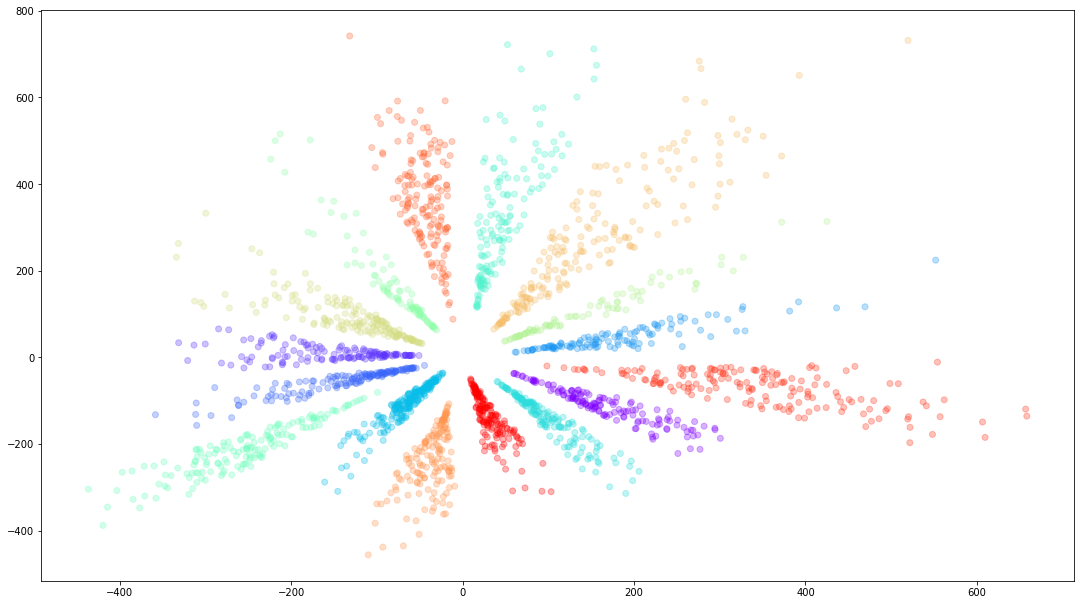

In [280]:
fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(embs[:,0], embs[:,1],  cmap="rainbow", c = labels_train.argmax(axis=1), alpha=0.3 )

fig.set_size_inches(18.5, 10.5)

0.4488479262672811

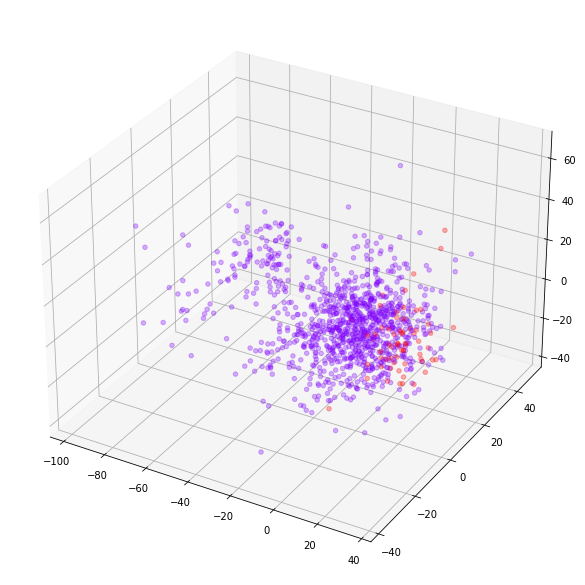

In [266]:


embs_test = model.embedding(model.transform_scaler(feature_data_test))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embs_test[:,0], embs_test[:,1], embs_test[:, 2], cmap="rainbow", c = labels_test.argmax(axis=1) == 0, alpha=0.3 )

fig.set_size_inches(18.5, 10.5)

labels_scores = model.classifier(embs_test)
labels_pred=  labels_scores.numpy().argmax(axis=1)
sum(labels_pred == labels_test.argmax(axis=1)) / len(labels_test)

In [232]:
fmeasure

0.26622524457170127